In [1]:
#dataset

import pandas as pd
import matplotlib.pyplot as plt

time_series_df = pd.read_csv('fft - edited - time.csv',nrows=1000)

print(time_series_df.head())

   Time  Router 0  Router 1  Router 2  Router 3  Router 4  Router 5  Router 6  \
0     5         1         0         0         0         0         0         0   
1     9         0         1         0         0         0         0         0   
2    13         0         0         1         0         0         0         0   
3    17         0         0         0         1         0         0         0   
4    21         0         0         0         0         0         0         0   

   Router 7  Router 8  Router 9  Router 10  Router 11  Router 12  Router 13  \
0         0         0         0          0          0          0          0   
1         0         0         0          0          0          0          0   
2         0         0         0          0          0          0          0   
3         0         0         0          0          0          0          0   
4         1         0         0          0          0          0          0   

   Router 14  Router 15  
0          0

In [2]:
# Common imports
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow
tensorflow.random.set_seed(1234)

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

Using TensorFlow backend.


In [3]:
time_series_df.set_index("Time",inplace=True)
time_series_df.head()

,Router 0,Router 1,Router 2,Router 3,Router 4,Router 5,Router 6,Router 7,Router 8,Router 9,Router 10,Router 11,Router 12,Router 13,Router 14,Router 15
Time,,,,,,,,,,,,,,,,
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
17,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


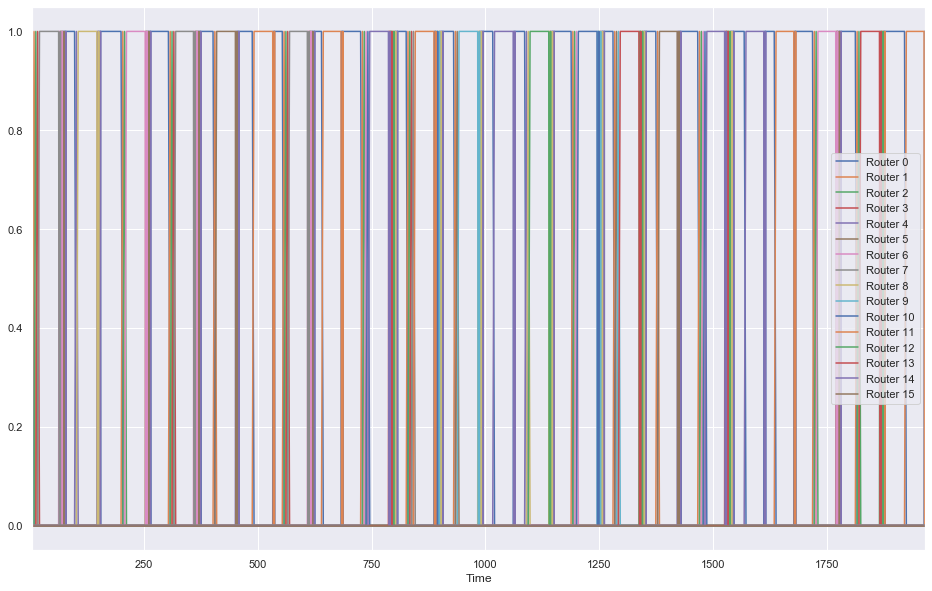

In [4]:
dataset_train = time_series_df[0:500]
dataset_test = time_series_df[501:999]
dataset_train.plot(figsize = (16,10))

In [5]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

In [7]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [8]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [9]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [10]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [11]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [12]:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [13]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [14]:
mean_distr = data_train.mean(axis=0)

In [15]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

(0.0, 15)

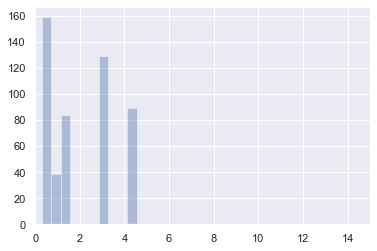

In [16]:
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10, 
             kde= False);
plt.xlim([0.0,15])

Text(0.5, 0, 'Mahalanobis dist')

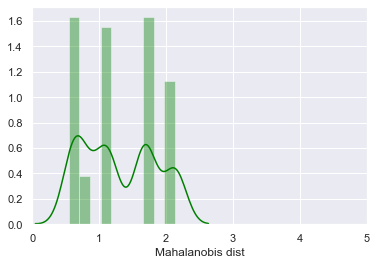

In [17]:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [18]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
Time,,,
1967,1.146718,3.909691,False
1967,1.687039,3.909691,False
1971,1.687039,3.909691,False
1982,1.687039,3.909691,False
1986,1.146718,3.909691,False


In [19]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')

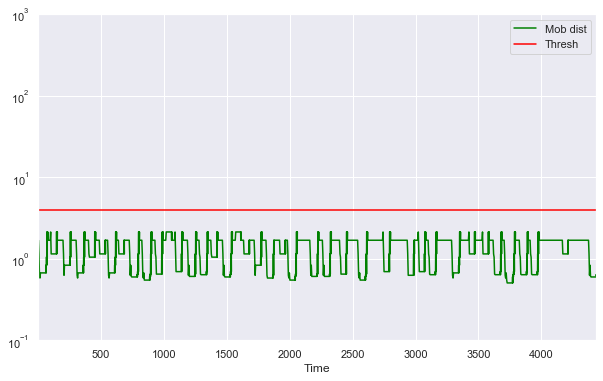

In [20]:
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3], color = ['green','red'])

In [24]:
seed(10)
import numpy as np
np.random.seed(10)
act_func = 'elu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=100
BATCH_SIZE=10

In [25]:
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)

Train on 475 samples, validate on 25 samples
Epoch 1/100
475/475 [==============================] - 1s 2ms/step - loss: 0.0656 - val_loss: 0.0603
Epoch 2/100
475/475 [==============================] - 0s 246us/step - loss: 0.0549 - val_loss: 0.0564
Epoch 3/100
475/475 [==============================] - 0s 261us/step - loss: 0.0506 - val_loss: 0.0550
Epoch 4/100
475/475 [==============================] - 0s 236us/step - loss: 0.0481 - val_loss: 0.0542
Epoch 5/100
475/475 [==============================] - 0s 223us/step - loss: 0.0463 - val_loss: 0.0538
Epoch 6/100
475/475 [==============================] - 0s 273us/step - loss: 0.0448 - val_loss: 0.0532
Epoch 7/100
475/475 [==============================] - 0s 261us/step - loss: 0.0434 - val_loss: 0.0522
Epoch 8/100
475/475 [==============================] - 0s 276us/step - loss: 0.0418 - val_loss: 0.0506
Epoch 9/100
475/475 [==============================] - 0s 286us/step - loss: 0.0398 - val_loss: 0.0488
Epoch 10/100
475/475 [========

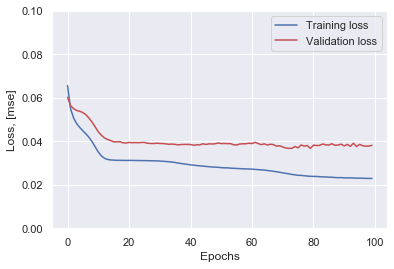

In [26]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.1])
plt.show()

(0.0, 0.5)

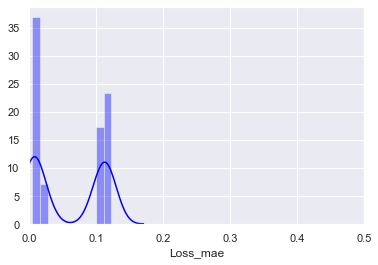

In [27]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.5])

In [28]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.3
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
Time,,,
1967,0.109324,0.3,False
1967,0.007634,0.3,False
1971,0.007634,0.3,False
1982,0.007634,0.3,False
1986,0.109324,0.3,False


In [29]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.3
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

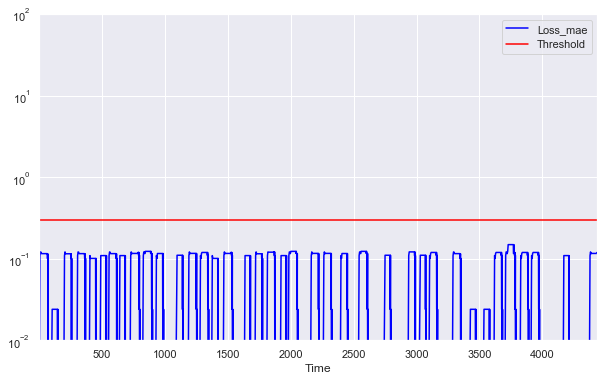

In [30]:
scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])